# 군집화(Clustering)
- 앞서 df_train_final 데이터 셋에 존재하는 연속형 변수들과 취급액(sales)의 상관관계를 확인해보았다.
- 하지만 판매량(pd_count)외에 상관관계가 높은 변수들은 존재하지 않았다.
    - 판매량의 경우 취급액과 높은 양의 상관관계가 있는 것이 당연함...
- 따라서 **군집화(Clustering)**를 통해 유의미한 패턴 및 요인들을 발견해보고자 한다!!

**<Raw Data 변수 설명>**
1. date: 방송일시
2. exp_mins: 노출(분)
3. mom_code: 마더코드
4. pd_code: 상품코드
5. pd_name: 상품명
6. pd_group: 상품군
7. pd_price: 판매단가
8. sales: 취급액
    - 취급액 = 판매단가 x 주문량
9. weekdays: 요일
10. seasons: 계절
    - 1: 겨울(winter): 12 ~ 2월
    - 2: 봄(spring): 3 ~ 5월
    - 3: 여름(summer): 6 ~ 8월
    - 4: 가을(autumn): 9 ~ 11월
11. rating: 시청률
    - 단위는 "%"
    - exp_mins(노출(분))을 기준으로 평균 값을 계산
12. temp: 기온
13. rain: 강수량
14. humidity: 습도
15. snow: 적설량
16. dust: 미세먼지 농도
17. is_rain: 비 내림 여부
    - 0: 비 내리지 않음
    - 1: 비 내림
18. is_snow: 눈 내림 여부
    - 0: 눈 내리지 않음
    - 1: 눈 내림

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

# for문 진행 현황을 확인할 수 있는 패키지
from tqdm.notebook import tqdm

# 여러 개의 데이터 프레임을 한 번에 merge 해주기 위한 패키지
from functools import reduce

# 이 두 줄의 코드는 matplotlib의 기본 scheme말고, seaborn scheme을 세팅해준다
# 일일이 graph의 font size를 지정할 필요 없이, seaborn의 font_scale을 사용하면 편리하다
plt.style.use('seaborn')
sns.set(font_scale = 2.5)

# 그래프에서 한글 폰트 깨지는 문제를 해결해주기 위한 코드
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname = path).get_name()
    rc('font', family = font_name)
else:
    print('Unknown system... sorry~~~~')

# 데이터 셋 확인

In [2]:
df_train = pd.read_csv('C:/Users/Playdata/2020_Bigcontest_working/dataset/df_train_final2.csv')
df_train

,date,exp_mins,mom_code,pd_code,pd_name,pd_group,pd_price,sales,weekdays,seasons,...,snow,dust,is_rain,is_snow,pd_count,month,day,hour,month_cat,hour_cat
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,Tuesday,1,...,NaN,65.0,0,0,53,1,1,6,상반기,오전
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,Tuesday,1,...,NaN,65.0,0,0,110,1,1,6,상반기,오전
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,Tuesday,1,...,NaN,65.0,0,0,82,1,1,6,상반기,오전
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,Tuesday,1,...,NaN,65.0,0,0,175,1,1,6,상반기,오전
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,Tuesday,1,...,NaN,65.0,0,0,168,1,1,6,상반기,오전
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37367,2019-12-31 23:40:00,20.0,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000.0,Tuesday,1,...,NaN,24.0,0,0,69,12,31,23,하반기,밤
37368,2020-01-01 00:00:00,20.0,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000.0,Wednesday,1,...,NaN,27.0,0,0,287,1,1,0,상반기,심야
37369,2020-01-01 00:00:00,20.0,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000.0,Wednesday,1,...,NaN,27.0,0,0,622,1,1,0,상반기,심야
37370,2020-01-01 00:00:00,20.0,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000.0,Wednesday,1,...,NaN,27.0,0,0,88,1,1,0,상반기,심야


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37372 entries, 0 to 37371
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       37372 non-null  object 
 1   exp_mins   37372 non-null  float64
 2   mom_code   37372 non-null  int64  
 3   pd_code    37372 non-null  int64  
 4   pd_name    37372 non-null  object 
 5   pd_group   37372 non-null  object 
 6   pd_price   37372 non-null  int64  
 7   sales      37372 non-null  float64
 8   weekdays   37372 non-null  object 
 9   seasons    37372 non-null  int64  
 10  rating     37372 non-null  float64
 11  temp       37372 non-null  float64
 12  rain       37372 non-null  float64
 13  humidity   37372 non-null  float64
 14  snow       368 non-null    float64
 15  dust       37372 non-null  float64
 16  is_rain    37372 non-null  int64  
 17  is_snow    37372 non-null  int64  
 18  pd_count   37372 non-null  int64  
 19  month      37372 non-null  int64  
 20  day   

# 데이터 타입 변경
- 분석에 사용할 컬럼들 중, 범주형 변수들의 데이터 타입을 'category'로 변경해주겠다.

In [4]:
categoricalFeatureNames = ['month', 'day', 'hour', 'month_cat', 'hour_cat', 'weekdays', 'seasons',
                           'pd_group', 'is_rain', 'is_snow']

for var in categoricalFeatureNames:
    df_train[var] = df_train[var].astype('category')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37372 entries, 0 to 37371
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   date       37372 non-null  object  
 1   exp_mins   37372 non-null  float64 
 2   mom_code   37372 non-null  int64   
 3   pd_code    37372 non-null  int64   
 4   pd_name    37372 non-null  object  
 5   pd_group   37372 non-null  category
 6   pd_price   37372 non-null  int64   
 7   sales      37372 non-null  float64 
 8   weekdays   37372 non-null  category
 9   seasons    37372 non-null  category
 10  rating     37372 non-null  float64 
 11  temp       37372 non-null  float64 
 12  rain       37372 non-null  float64 
 13  humidity   37372 non-null  float64 
 14  snow       368 non-null    float64 
 15  dust       37372 non-null  float64 
 16  is_rain    37372 non-null  category
 17  is_snow    37372 non-null  category
 18  pd_count   37372 non-null  int64   
 19  month      37372 non-null

# 범주형 변수 추출

In [5]:
df_cate = df_train[['month', 'day', 'hour', 'month_cat', 'hour_cat', 'weekdays', 
                    'seasons', 'pd_group', 'is_rain', 'is_snow']]
df_cate.head()

,month,day,hour,month_cat,hour_cat,weekdays,seasons,pd_group,is_rain,is_snow
0,1,1,6,상반기,오전,Tuesday,1,의류,0,0
1,1,1,6,상반기,오전,Tuesday,1,의류,0,0
2,1,1,6,상반기,오전,Tuesday,1,의류,0,0
3,1,1,6,상반기,오전,Tuesday,1,의류,0,0
4,1,1,6,상반기,오전,Tuesday,1,의류,0,0


## 범주형 변수 One-Hot Encoding

In [6]:
df_cate = pd.get_dummies(df_cate, columns = ['month'], prefix = 'month')
df_cate = pd.get_dummies(df_cate, columns = ['day'], prefix = 'day')
df_cate = pd.get_dummies(df_cate, columns = ['hour'], prefix = 'hour')
df_cate = pd.get_dummies(df_cate, columns = ['month_cat'], prefix = 'month_cat')
df_cate = pd.get_dummies(df_cate, columns = ['hour_cat'], prefix = 'hour_cat')
df_cate = pd.get_dummies(df_cate, columns = ['weekdays'], prefix = 'weekdays')
df_cate = pd.get_dummies(df_cate, columns = ['seasons'], prefix = 'seasons')
df_cate = pd.get_dummies(df_cate, columns = ['pd_group'], prefix = 'pd_group')
df_cate = pd.get_dummies(df_cate, columns = ['is_rain'], prefix = 'is_rain')
df_cate = pd.get_dummies(df_cate, columns = ['is_snow'], prefix = 'is_snow')

# 연속형 변수 추출 및 Feature Scaling
- 스케일링 기법으로는 ```MinMaxScaler()```를 사용할 것이다.

In [7]:
# 연속형 변수만 추출된 데이터 셋
df_cont = df_train[['exp_mins', 'pd_price', 'rating', 'temp', 'rain', 'humidity', 'dust']]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df_cont)
df_cont_scaled = scaler.transform(df_cont)

# transform()을 수행하면 스케일 변환된 데이터 셋이 Numpy ndarray로 반환되기 때문에, 이를 DataFrame으로 변경
df_cont_scaled = pd.DataFrame(df_cont_scaled, columns = df_cont.columns)

df_cont_scaled.head()

,exp_mins,pd_price,rating,temp,rain,humidity,dust
0,0.46714,0.003423,0.0,0.061053,0.04902,0.574713,0.237736
1,0.46714,0.003423,0.0,0.061053,0.04902,0.574713,0.237736
2,0.46714,0.003423,0.0,0.061053,0.04902,0.574713,0.237736
3,0.46714,0.003423,0.0,0.061053,0.04902,0.574713,0.237736
4,0.46714,0.003423,0.0,0.061053,0.04902,0.574713,0.237736


# 군집화를 위한 데이터 셋 생성
- "원-핫 인코딩 처리된 범주형 변수" + "스케일링 처리된 연속형 변수"

In [8]:
df_cate.shape

(37372, 96)

In [9]:
df_cont_scaled.shape

(37372, 7)

In [10]:
df_cluster = pd.concat([df_cate, df_cont_scaled], axis = 1)
df_cluster

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,...,is_rain_1,is_snow_0,is_snow_1,exp_mins,pd_price,rating,temp,rain,humidity,dust
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0.46714,0.003423,0.000000,0.061053,0.04902,0.574713,0.237736
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0.46714,0.003423,0.000000,0.061053,0.04902,0.574713,0.237736
2,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0.46714,0.003423,0.000000,0.061053,0.04902,0.574713,0.237736
3,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0.46714,0.003423,0.000000,0.061053,0.04902,0.574713,0.237736
4,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0.46714,0.003423,0.000000,0.061053,0.04902,0.574713,0.237736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37367,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0.46714,0.017077,0.172264,0.071579,0.00000,0.402299,0.083019
37368,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0.46714,0.020866,0.219676,0.090526,0.00000,0.321839,0.094340
37369,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0.46714,0.019603,0.219676,0.090526,0.00000,0.321839,0.094340
37370,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0.46714,0.018340,0.219676,0.090526,0.00000,0.321839,0.094340


# 군집화(Clustering)
- **K-means 알고리즘**을 사용하여 군집화를 수행해보도록 하겠다.
    - K-means 알고리즘의 경우, 연속형 변수들에 대해서만 수행이 가능한데...
    - 우선 범주형 변수들을 원-핫 인코딩 처리해서 돌려보도록 하겠다.

### 군집화를 위한 최적의 K 값 찾기

- 먼저 **Elbow 방법**을 사용해서 최적의 K 값을 확인해보겠다.

C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


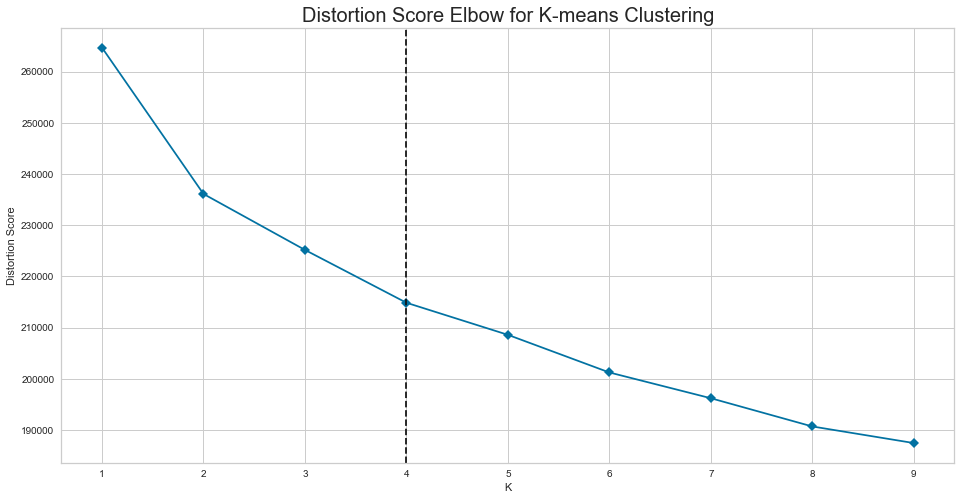

In [11]:
from sklearn.cluster import KMeans
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

plt.figure(figsize = (16, 8))

kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k = (1, 10), timings = False)
visualizer.fit(df_cluster)

plt.title('Distortion Score Elbow for K-means Clustering', fontsize = 20)
plt.xlabel('K')
plt.ylabel('Distortion Score')
plt.show()

- Elbow 방법으로 찾은 최적의 K 값은 4라고 나온다.
    - 하지만 내가 봤을 때는 **k = 2**와 **k = 3**인 경우도 나쁘지 않아 보인다.
- 따라서 **실루엣 다이어그램**을 통해 다시 한 번 최적의 K 값을 찾아보도록 하겠다.
    - 각 군집별 평균 실루엣 계수의 시각화를 통한 군집 개수 최적화 방법이다.
    - K 값은 2부터 5까지의 값을 사용해 볼 것이다.

In [12]:
### 여러 개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize = (6 * n_cols, 5), nrows = 1, ncols = n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산
        clusterer = KMeans(n_clusters = n_cluster, init = 'k-means++', random_state = 0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : ' + str(n_cluster) + '\n' \
                           'Silhouette Score :' + str(round(sil_avg, 3)))
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수 별로 fill_betweenx( )형태의 막대 그래프 표현
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels == i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                   facecolor = color, edgecolor = color, alpha = 0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x = sil_avg, color = "red", linestyle = "--")

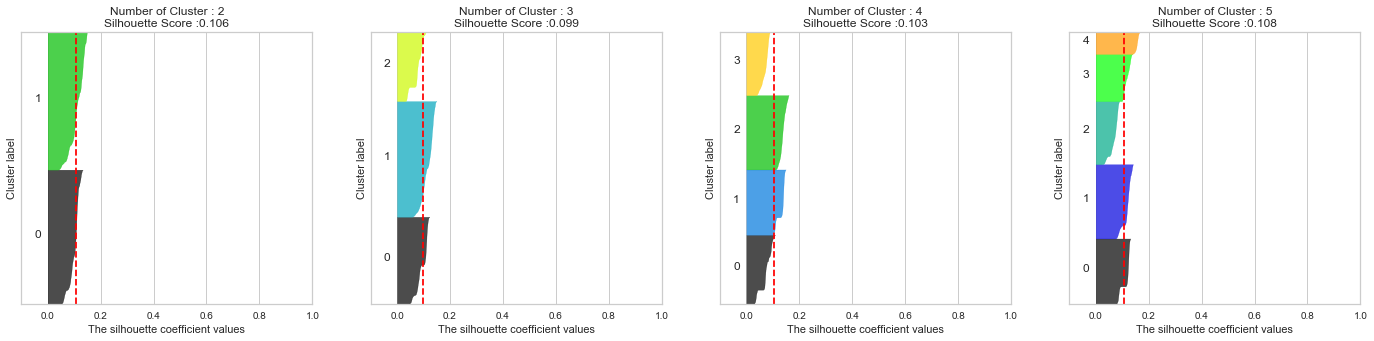

In [13]:
visualize_silhouette([2, 3, 4, 5], df_cluster)

C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000029844938748>,
                     colors=None, is_fitted='auto', model=None)

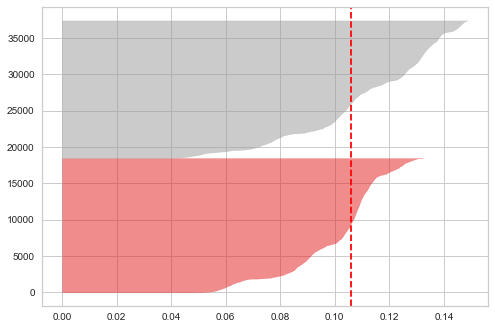

In [14]:
# k = 2인 경우
kmeans_2 = KMeans(n_clusters = 2, init = 'k-means++', random_state = 0)
visualizer = SilhouetteVisualizer(kmeans_2)
visualizer.fit(df_cluster)

C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000298449D8B48>,
                     colors=None, is_fitted='auto', model=None)

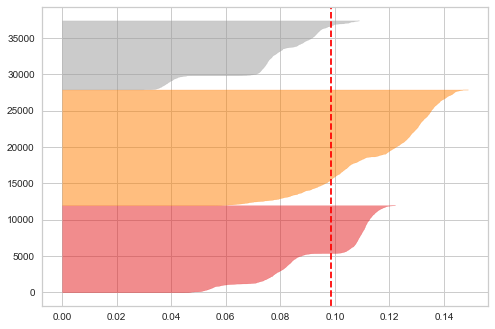

In [15]:
# k = 3인 경우
kmeans_3 = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0)
visualizer = SilhouetteVisualizer(kmeans_3)
visualizer.fit(df_cluster)

C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000298449DDBC8>,
                     colors=None, is_fitted='auto', model=None)

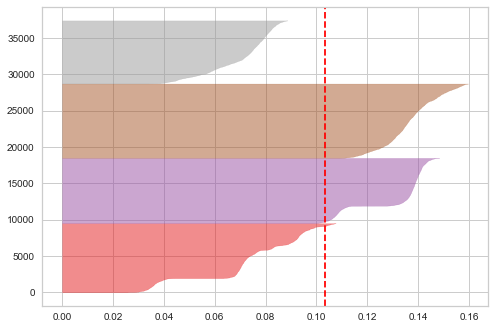

In [16]:
# k = 4인 경우
kmeans_4 = KMeans(n_clusters = 4, init = 'k-means++', random_state = 0)
visualizer = SilhouetteVisualizer(kmeans_4)
visualizer.fit(df_cluster)

C:\Users\Playdata\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000298435C7948>,
                     colors=None, is_fitted='auto', model=None)

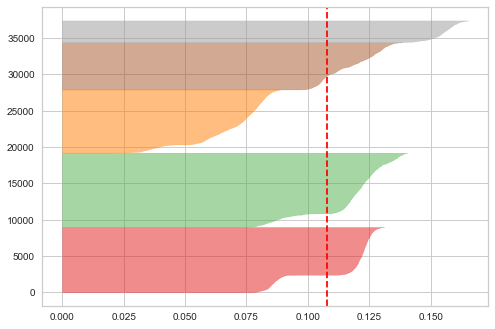

In [17]:
# k = 5인 경우
kmeans_5 = KMeans(n_clusters = 5, init = 'k-means++', random_state = 0)
visualizer = SilhouetteVisualizer(kmeans_5)
visualizer.fit(df_cluster)

### 최적의 K 값으로 군집화 수행
- **Elbow 방법**과 **실루엣 다이어그램** 결과를 통해, **최적의 K 값은 2라고 판단**하였다.

In [18]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300, random_state = 0)
kmeans.fit(df_cluster)

# 각 데이터가 속하는 군집을 의미하는 'cluster' 변수를 df_train_fill_dust 데이터 셋에 추가
df_train['cluster'] = kmeans.labels_
df_train.cluster.value_counts()

1    18925
0    18447
Name: cluster, dtype: int64

# Cluster 변수가 추가된 데이터 셋 csv 파일로 내보내기

In [20]:
df_train.to_csv('C:/Users/Playdata/2020_Bigcontest_working/dataset/clustered.csv', index = False)